## Importing

In [1]:
## %cd /Users/bezdek/Box/DCL_ARCHIVE/Documents/Events/exp148_Corpus/viz

import pickle as pkl
import pandas as pd
import numpy as np

# For panel visualizations:
import panel as pn
#import param
# For displaying images:
import cv2
from IPython.display import clear_output, Image, display, HTML
from scipy.spatial.distance import cosine
from scipy.ndimage import gaussian_filter1d
from glob import glob
import os
import sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from copy import deepcopy
#from run_sem_with_features import preprocess_skel
import joblib

pd.set_option('use_inf_as_na', True)
pn.extension()

## Initializing Variables and Widgets

In [2]:
# Note: to add another global variable, need to init, add to global term, and define an update based on run
# TODO: download new inputdf, diagnostic, gt_freqs and change below variables to visualize.

title = '# Visualize Output'
# tag = 'feb_17_vw300_lmda1e10_df100'
#tag = 'mar_23_depth_pos_20_nh32'
tag = 'april_18_test_refactor_correct_pca_no_cache'
default_run = '1.1.9'
# epoch = '_18'
# test epochs 0,5,10
epoch = '1'

# Load sample input dfs:
tags = glob(f'output/run_sem/*/')
tags = [x.split('/')[-2] for x in tags if any(i.isdigit() for i in x)]
tag_select = pn.widgets.Select(name='Select Tag', options=tags, value=tag)
runs = glob(f'output/run_sem/{tag}/*_kinect_trim{tag}_diagnostic_*.pkl')
runs = sorted(list(set([os.path.basename(x).split('_')[0] for x in runs])))
run_select = pn.widgets.Select(name='Select Run', options=runs, value=default_run)
skel_checkbox = pn.widgets.Checkbox(name='Display Skeleton?')
obj_checkbox = pn.widgets.Checkbox(name='Display Nearest Objects?')
z_checkbox = pn.widgets.Checkbox(name='Z-score time courses?')
# Options and values for these widgets are just placeholders, will be updated based on run by listen_to_run 
#frame_slider = pn.widgets.DiscreteSlider(name='Select Frame', options=list([0, 1, 2, 3]), value=0)
#text_input = pn.widgets.TextInput(name='Second', placeholder='Enter timepoint (in second)')
#second_slider = pn.widgets.DiscreteSlider(name='Select Second', options=list([0, 1, 2, 3]), value=0)
#tc_feature_select = pn.widgets.MultiSelect(name='Select Time Course Features', value=['features[3]', 'features[4]'], options=['features[3]','features[4]'], size=8)
#pair_feature_select = pn.widgets.MultiSelect(name='Select 2 or 3 Features for Comparison', value=['features[3]' ,'features[4]'],options=['features[3],features[4]'], size=8)

epochs=glob(f'output/run_sem/{tag}/{default_run}_kinect_trim{tag}_diagnostic_*.pkl')
epochs = [x.split('.')[-2].split('_')[-1] for x in epochs]
epochs.sort(key=int)
epoch_select = pn.widgets.MultiSelect(name='Select Epochs', value=epochs,
    options=epochs)
second_interval = 1 # interval to group boundaries
frame_per_second = 3 # sampling rate to input to SEM
fps = 25.0 # kinect videos
frame_interval = frame_per_second * second_interval

# declare global variables that will be used for each individual runs (to save loading time)
skel_df, appear_df, flow_df, objdf, objhand_df, anchored_frames, appear_df_post, flow_df_post, skel_df_post, gt_freqs, \
sem_readouts, inputdf, first_frame,offset, \
        pca_input_df, pred_skel_df, skel_df_unscaled, \
        categories, pred_objhand, word2vec, objdf_z = [None] * 21

#glove_vectors = pkl.load(open('gen_sim_glove_50.pkl', 'rb'))

## Linking Widgets and Updating Global Variables

In [3]:
'''
def second_to_frame(frame_slider, second):
    frameid = int(float(second.new) * 25)
    while frameid not in anchored_frames:
        frameid += 1
    frame_slider.value = frameid
second_slider.link(frame_slider, callbacks={'value': second_to_frame})
def text_to_secondsl(second_slider, text):
    second = int(text.new)
    second_slider.value = second
text_input.link(second_slider, callbacks={'value': text_to_secondsl})
''' 

@pn.depends(tag_select.param.value)
def update_run_options(tag_select):
    runs = glob(f'output/run_sem/{tag}/*_kinect_trim{tag}_diagnostic_*.pkl')
    runs = sorted(list(set([os.path.basename(x).split('_')[0] for x in runs])))
    run_select.value=runs[0]
    run_select.options=runs

@pn.depends(tag_select.param.value,run_select.param.value)
def update_epoch_options(tag_select,run_select):
    epochs=glob(f'output/run_sem/{tag_select}/{run_select}_kinect_trim{tag_select}_inputdf_*.pkl')
    epochs = [x.split('.')[-2].split('_')[-1] for x in epochs]
    epochs.sort(key=int)
    epoch_select.value=epochs
    epoch_select.options=epochs
    
@pn.depends(tag_select.param.value,run_select.param.value,epoch_select.param.value)
def listen_to_run(tag_select,run_select,epoch_select):
    global skel_df, appear_df, flow_df, objdf, objhand_df, anchored_frames, appear_df_post, flow_df_post, skel_df_post, \
        gt_freqs, sem_readouts, inputdf, first_frame, offset, \
        pca_input_df, pred_skel_df, skel_df_unscaled, \
        categories, pred_objhand, word2vec, objdf_z, epoch
    
    #epochs=glob(f'output/run_sem/{run_select}_kinect_trim{tag}_inputdf_*.pkl')
    #epochs = [x.split('.')[-2].split('_')[-1] for x in epochs]
    #epochs.sort(key=int)
    epoch=epoch_select
    # These are dataframes before processing (standardizing, interpolating, concatenating, dropna, resample)
    #skel_df=pd.read_csv(f'output/skel/{run_select}_kinect_skel_features.csv')
    #appear_df = pd.read_csv(f'output/appear/{run_select}_kinect_appear.csv')
    #flow_df=pd.read_csv(f'output/vid/{run_select}_kinect_video_features.csv')
    # Caching frames to speed up interactive time
#     anchored_frames = pkl.load(open(f'output/run_sem/{run_select}_kinect_trimjan_09_333_less_boundaries_frames.pkl', 'rb'))
    #anchored_frames = joblib.load(f'output/run_sem_test/{run_select}_kinect_trimjan_27_pca_frames.joblib')
    # This data is for plotting diagnostic results
    gt_freqs = pkl.load(open(f'output/run_sem/{tag_select}/{run_select}_kinect_trim{tag_select}_gtfreqs.pkl', 'rb'))
    sem_readouts = []
    inputdf = []
    for i,v in enumerate(epoch):
        sem_readouts.append(pkl.load(open(f'output/run_sem/{tag_select}/{run_select}_kinect_trim{tag_select}_diagnostic_{v}.pkl', 'rb')))
    # Preprocess likelihoods because old_lik contains new likelihoods and repeat likelihoods as well

        sem_readouts[i]['frame_dynamics']['old_lik'] = [[l for l in all_lik if
                                                  not(np.isclose(l, new_lik, rtol=1e-2) or np.isclose(l, repeat_lik, rtol=1e-2))]
                                                 for all_lik, new_lik, repeat_lik in
                                                 zip(sem_readouts[i]['frame_dynamics']['old_lik'], sem_readouts[i]['frame_dynamics']['new_lik'], sem_readouts[i]['frame_dynamics']['repeat_lik'])]
        sem_readouts[i]['frame_dynamics']['old_lik']  = [l if len(l) else [-5000] for l in sem_readouts[i]['frame_dynamics']['old_lik']]
        sem_readouts[i]['frame_dynamics']['old_prior'] = [[p for p in all_prior if
                                              not(np.isclose(p, new_prior, rtol=1e-2) or np.isclose(p, repeat_prior, rtol=1e-2))]
                                             for all_prior, new_prior, repeat_prior in
                                             zip(sem_readouts[i]['frame_dynamics']['old_prior'], sem_readouts[i]['frame_dynamics']['new_prior'], sem_readouts[i]['frame_dynamics']['repeat_prior'])]
        sem_readouts[i]['frame_dynamics']['old_prior']  = [p if len(p) else [-5000] for p in sem_readouts[i]['frame_dynamics']['old_prior']]
    
    # A list of dataframes after processing (appear->flow->skel->objhand). It also contains other dataframes for plotting (3 nearest_objects->object_coordinates)
    # and x_train and x_inferred of SEM.
        inputdf.append(pkl.load(open(f'output/run_sem/{tag_select}/{run_select}_kinect_trim{tag_select}_inputdf_{v}.pkl', 'rb')))
    # offset to align prediction boundaries with exact video timepoint
    #LEFT
    first_frame = inputdf[0].appear_post.index[0]
    offset = first_frame / fps / second_interval
    
    '''
    appear_df_post = inputdf[0][0]
    flow_df_post = inputdf[0][1]
    skel_df_post = inputdf[0][2]
    objdf=inputdf[0][5]
    # TODO: uncomment to test depth
    # objdf_z = inputdf[9]
    objhand_df=inputdf[0][3]
    # Prepare dataframes to plot input skeleton and predicted skeleton
    pca_input_df = inputdf[0][6]
    pred_skel_df = inputdf[0][7]
    skel_df_unscaled = skel_df_post.copy().loc[:, skel_df_post.columns]
    pred_skel_df = pred_skel_df.loc[:, skel_df_post.columns]
    pca_input_df = pca_input_df.loc[:, skel_df_post.columns]

    skel_df_unscaled = skel_df_unscaled * skel_df.std() + skel_df.mean()
    pred_skel_df = pred_skel_df * skel_df.std() + skel_df.mean()
    pca_input_df = pca_input_df * skel_df.std() + skel_df.mean()

    skel_df_unscaled['frame'] = skel_df_unscaled.index
    pred_skel_df['frame'] = pred_skel_df.index
#     pca_input_df['frame'] = pca_input_df.index
    pca_input_df.set_index(pred_skel_df.index, inplace=True)
    pca_input_df['frame'] = pca_input_df.index # This is a workaround, will remove after new results come
    for i in range(25):
        new_column = f'J{i}_Tracked'
        skel_df_unscaled[new_column] = 'Inferred'
        pred_skel_df[new_column] = 'Predicted'
        pca_input_df[new_column] = 'Inferred'
    # Add two new distances columns to objhand_df
    # TODO: refactor so that it doesn't change the original dataframe
    i=1
    dists=[0]
    euc_dists = [0]
    while i < len(objhand_df):
        dists.append(cosine(objhand_df.iloc[i],objhand_df.iloc[i-1]))
        euc_dists.append(np.linalg.norm(objhand_df.iloc[i] - objhand_df.iloc[i-1]))
        i+=1
    objhand_df['cosine']=dists
    objhand_df['euclid'] = euc_dists
    # Prepare a dictionary of word2vec for this particular run
    categories = set()
    for c in inputdf[0][4].columns:
        categories.update(inputdf[0][4].loc[:, c])
    if None in categories:
        categories.remove(None)

    pred_objhand = inputdf[0][7]
    pred_objhand = pred_objhand.loc[:, objhand_df.drop(['euclid', 'cosine'], axis=1, errors='ignore').columns]
    word2vec = dict()
    for category in categories:
        r = np.zeros(shape=(1, pred_objhand.shape[1]))
        try:
            r += glove_vectors[category]
        except Exception as e:
            words = category.split(' ')
            for w in words:
                w = w.replace('(', '').replace(')', '')
                r += glove_vectors[w]
            r /= len(words)
        word2vec[category] = r
    
        
    # Update sliders
    #frame_slider.options = list(anchored_frames.keys())
    #frame_slider.value=list(anchored_frames.keys())[0]
    #second_slider.options=list(np.arange(inputdf[0][0].index[0] // 25, inputdf[0][0].index[-1] // 25))
    #second_slider.value=inputdf[0][0].index[0] // 25

    #features = skel_df_post.columns.tolist()
    #tc_feature_select.options = features
    #tc_feature_select.value = [features[3],features[4]]
    #pair_feature_select.options=features
    #pair_feature_select.value=[features[3],features[4]]

    #epoch_select_l.value=epochs[0]
    #epoch_select_l.options=epochs
    #epoch_select_r.value=epochs[1]
    #epoch_select_r.options=epochs
    '''

    

## Appear Features

In [4]:
'''
@pn.depends(frame_slider.param.value,run_select.param.value)
def appear_plot(frame_slider,run_select): # start function
    # appear_df = pd.read_csv('output/appear/'+run_select+'_kinect_appear.csv')
    df = appear_df.reset_index()
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='appear', ax=ax)
    df.plot(kind='line', x='second', y='disappear', ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Appearances and Disappearances '+run_select)
    #ax.get_legend().remove()
    #plt.show()
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    plt.close(fig)
    return fig

@pn.depends(frame_slider.param.value,run_select.param.value)
def appear_plot_post(frame_slider,run_select): # start function
    # appear_df = pd.read_csv('output/appear/'+run_select+'_kinect_appear.csv')
    df = appear_df_post.reset_index()
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='appear', ax=ax)
    df.plot(kind='line', x='second', y='disappear', ax=ax)
    ax.axvline(frame_slider,linewidth=3, color = 'r', alpha=0.5)
    plt.title('Appearances and Disappearances Post'+run_select)
    #ax.get_legend().remove()
    #plt.show()
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    plt.close(fig)
    return fig
    '''

"\n@pn.depends(frame_slider.param.value,run_select.param.value)\ndef appear_plot(frame_slider,run_select): # start function\n    # appear_df = pd.read_csv('output/appear/'+run_select+'_kinect_appear.csv')\n    df = appear_df.reset_index()\n    fig,ax = plt.subplots()\n    df['second'] = df['frame'] / 25\n    df.plot(kind='line', x='second', y='appear', ax=ax)\n    df.plot(kind='line', x='second', y='disappear', ax=ax)\n    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')\n    plt.title('Appearances and Disappearances '+run_select)\n    #ax.get_legend().remove()\n    #plt.show()\n    # Plotting diagnostic embeded in a function\n    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}\n    latest = 0\n    current = 0\n    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))\n    post = sem_readouts['e_hat']\n    switch = []\n    for i in post:\n        if i != current:\n            if i > latest:\n                switch

## Skeleton Features

In [5]:
'''
@pn.depends(tc_feature_select.param.value, frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def time_plot(tc_feature_select,frame_slider,z_checkbox,run_select): # start function
    skel_df['frame'] = (skel_df['sync_time'] * fps).apply(round).astype(int)
    df = skel_df.reset_index()
    if z_checkbox:
        for feat in tc_feature_select:
            df[feat] = (df[feat] - df[feat].mean())/df[feat].std(ddof=0)
            #df[feat]=df[feat].apply(zscore)
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / 25
    for feat in tc_feature_select:
        df.plot(kind='line', x='second', y=feat, alpha = 0.5,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Feature Time Course '+run_select)
    #plt.show()
    plt.close(fig)
    return fig

@pn.depends(pair_feature_select.param.value, frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def pair_plot(pair_feature_select,frame_slider,z_checkbox,run_select): # start function
    skel_df['frame'] = (skel_df['sync_time'] * fps).apply(round).astype(int)
    df = skel_df.reset_index()
    if z_checkbox:
        for feat in pair_feature_select:
            df[feat] = (df[feat] - df[feat].mean())/df[feat].std(ddof=0)
    pdf = df[df['frame'] == frame_slider]
        
    if len(pair_feature_select) == 2:
        fig,ax = plt.subplots()
        df.plot(kind='scatter', x=pair_feature_select[0], y=pair_feature_select[1],alpha=0.5,c=df['frame'],colormap='viridis',ax=ax)
        ax.plot(pdf[pair_feature_select[0]],pdf[pair_feature_select[1]],marker='o',markersize=15,color='r',alpha=0.5)
    elif len(pair_feature_select) == 3:
        fig,ax=plt.subplots(subplot_kw=dict(projection='3d'))
        p=ax.scatter(df[pair_feature_select[0]],df[pair_feature_select[1]],df[pair_feature_select[2]],c=df['frame'],cmap='viridis')
        ax.plot(pdf[pair_feature_select[0]],pdf[pair_feature_select[1]],pdf[pair_feature_select[2]],marker='o',markersize=15,color='r')
        ax.set_xlabel(pair_feature_select[0])
        ax.set_ylabel(pair_feature_select[1])
        ax.set_zlabel(pair_feature_select[2])

        fig.colorbar(p)
    else:
        fig,ax = plt.subplots()
    plt.title('Compare Features '+run_select)
    plt.close(fig)
    return fig

@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_reduced_features(frame_slider, run_select):

    x_train = skel_df_post.to_numpy()
    pca = PCA(n_components=2, whiten=True)
    x_train = pca.fit_transform(x_train)
    df = pd.DataFrame(x_train, index=skel_df_post.index, columns=['pc_1', 'pc_2'])
    fig, ax = plt.subplots()
    df.plot(kind='scatter', x=df.columns[0], y=df.columns[1],alpha=0.5,c=df.index,colormap='viridis',ax=ax)
    ax.plot(df.loc[frame_slider, 'pc_1'], df.loc[frame_slider, 'pc_2'], marker='o',markersize=15,color='r',alpha=0.5)
    ax.set_title('Principal Components for Skeletons')
    ax.axvline(frame_slider,linewidth=3, color = 'r', alpha=0.5)
    plt.close()
    return fig

@pn.depends(frame_slider.param.value, run_select.param.value)
def skel_plot_post(frame_slider, run_select):

    x_train = skel_df_post.to_numpy()
    pca = PCA(n_components=0.9, whiten=True)
    x_train = pca.fit_transform(x_train)
    change = [0]
    for i in range(1, len(x_train)):
        change.append(cosine(x_train[i], x_train[-1]))
    df = pd.DataFrame(change, index=skel_df_post.index, columns=['feature_change'])
    df = df.reset_index()
    df['feature_change'] = gaussian_filter1d(df['feature_change'].values, 5)
    fig, ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='feature_change',alpha=0.5,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Skel PCA Cosine Disntance '+run_select+ f'\n{len(pca.explained_variance_)} components with {round(np.sum(pca.explained_variance_ratio_) * 100)}% variance')
    plt.close()
    return fig

@pn.depends(frame_slider.param.value, run_select.param.value)
def skel_plot_post_euclid(frame_slider, run_select):

    x_train = skel_df_post.to_numpy()
    pca = PCA(n_components=0.9, whiten=True)
    x_train = pca.fit_transform(x_train)
    change = [0]
    for i in range(1, len(x_train)):
        change.append(np.linalg.norm(x_train[i] - x_train[-1]) / x_train.shape[1])
    df = pd.DataFrame(change, index=skel_df_post.index, columns=['feature_change'])
    df = df.reset_index()
    df['feature_change'] = gaussian_filter1d(df['feature_change'].values, 5)
    fig, ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='feature_change',alpha=0.5,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Skel PCA Euclidean Distance '+run_select+ f'\n{len(pca.explained_variance_)} components with {round(np.sum(pca.explained_variance_ratio_) * 100)}% variance')
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    plt.close()
    return fig
    '''

"\n@pn.depends(tc_feature_select.param.value, frame_slider.param.value,z_checkbox.param.value,run_select.param.value)\ndef time_plot(tc_feature_select,frame_slider,z_checkbox,run_select): # start function\n    skel_df['frame'] = (skel_df['sync_time'] * fps).apply(round).astype(int)\n    df = skel_df.reset_index()\n    if z_checkbox:\n        for feat in tc_feature_select:\n            df[feat] = (df[feat] - df[feat].mean())/df[feat].std(ddof=0)\n            #df[feat]=df[feat].apply(zscore)\n    fig,ax = plt.subplots()\n    df['second'] = df['frame'] / 25\n    for feat in tc_feature_select:\n        df.plot(kind='line', x='second', y=feat, alpha = 0.5,ax=ax)\n    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')\n    plt.title('Feature Time Course '+run_select)\n    #plt.show()\n    plt.close(fig)\n    return fig\n\n@pn.depends(pair_feature_select.param.value, frame_slider.param.value,z_checkbox.param.value,run_select.param.value)\ndef pair_plot(pair_feature_sel

## Object-Hand Features

In [6]:
'''

@pn.depends(frame_slider.param.value,run_select.param.value)
def objhand_plot(frame_slider,run_select): # start function
    x_train = objhand_df.drop(['cosine', 'euclid'], errors='ignore').to_numpy()
    pca = PCA(n_components=0.9, whiten=True)
    x_train = pca.fit_transform(x_train)
    change = [0]
    for i in range(1, len(x_train)):
        change.append(np.linalg.norm(x_train[i] - x_train[-1]) / x_train.shape[1])
    df = pd.DataFrame(change, index=objhand_df.index, columns=['feature_change'])
    df = df.reset_index()
    df['feature_change'] = gaussian_filter1d(df['feature_change'].values, 5)
    fig, ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='feature_change',alpha=0.5,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Objhand PCA Euclid Distance '+run_select+ f'\n{len(pca.explained_variance_)} components with {round(np.sum(pca.explained_variance_ratio_) * 100)}% variance')

    
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    #plt.show()
    plt.close(fig)
    return fig
    '''

"\n\n@pn.depends(frame_slider.param.value,run_select.param.value)\ndef objhand_plot(frame_slider,run_select): # start function\n    x_train = objhand_df.drop(['cosine', 'euclid'], errors='ignore').to_numpy()\n    pca = PCA(n_components=0.9, whiten=True)\n    x_train = pca.fit_transform(x_train)\n    change = [0]\n    for i in range(1, len(x_train)):\n        change.append(np.linalg.norm(x_train[i] - x_train[-1]) / x_train.shape[1])\n    df = pd.DataFrame(change, index=objhand_df.index, columns=['feature_change'])\n    df = df.reset_index()\n    df['feature_change'] = gaussian_filter1d(df['feature_change'].values, 5)\n    fig, ax = plt.subplots()\n    df['second'] = df['frame'] / 25\n    df.plot(kind='line', x='second', y='feature_change',alpha=0.5,ax=ax)\n    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')\n    plt.title('Objhand PCA Euclid Distance '+run_select+ f'\n{len(pca.explained_variance_)} components with {round(np.sum(pca.explained_variance_ratio_) *

## Video Features

In [7]:
'''
@pn.depends(frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def flow_plot(frame_slider,z_checkbox,run_select): # start function
    # flow_df=pd.read_csv('output/vid/'+run_select+'_kinect_video_features.csv')
    df = flow_df.reset_index()
    if z_checkbox:
        df['pixel_correlation'] = (df['pixel_correlation'] - df['pixel_correlation'].mean())/df['pixel_correlation'].std(ddof=0)
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df.plot(kind='line', x='second', y='pixel_correlation', ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Interframe Pixel Correlation '+run_select)
    ax.get_legend().remove()
    #plt.show()
    plt.close(fig)
    return fig

@pn.depends(frame_slider.param.value,z_checkbox.param.value,run_select.param.value)
def flow_plot_post(frame_slider,z_checkbox,run_select): # start function
    # flow_df=pd.read_csv('output/vid/'+run_select+'_kinect_video_features.csv')
    df = flow_df_post.reset_index()
    if z_checkbox:
        df['optical_flow_avg'] = (df['optical_flow_avg'] - df['optical_flow_avg'].mean())/df['optical_flow_avg'].std(ddof=0)
    fig,ax = plt.subplots()
    df['second'] = df['frame'] / 25
    df['optical_flow_avg'] = gaussian_filter1d(df['optical_flow_avg'].values, 5)
    df.plot(kind='line', x='second', y='optical_flow_avg', ax=ax, alpha=0.5)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    plt.title('Interframe Optical Flow Post '+run_select)
    ax.get_legend().remove()
    # Plotting diagnostic embeded in a function

    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    #plt.show()
    plt.close(fig)
    return fig
'''

"\n@pn.depends(frame_slider.param.value,z_checkbox.param.value,run_select.param.value)\ndef flow_plot(frame_slider,z_checkbox,run_select): # start function\n    # flow_df=pd.read_csv('output/vid/'+run_select+'_kinect_video_features.csv')\n    df = flow_df.reset_index()\n    if z_checkbox:\n        df['pixel_correlation'] = (df['pixel_correlation'] - df['pixel_correlation'].mean())/df['pixel_correlation'].std(ddof=0)\n    fig,ax = plt.subplots()\n    df['second'] = df['frame'] / 25\n    df.plot(kind='line', x='second', y='pixel_correlation', ax=ax)\n    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')\n    plt.title('Interframe Pixel Correlation '+run_select)\n    ax.get_legend().remove()\n    #plt.show()\n    plt.close(fig)\n    return fig\n\n@pn.depends(frame_slider.param.value,z_checkbox.param.value,run_select.param.value)\ndef flow_plot_post(frame_slider,z_checkbox,run_select): # start function\n    # flow_df=pd.read_csv('output/vid/'+run_select+'_kinect_vi

## Impose Skeletons and Objects on Frame

In [8]:
'''
def drawskel(frame_number,frame,skel_df,color=(255,0,0),thickness=2):
    # frame_number : video frame to select skeleton joints
    # frame : image frame to draw on
    # skel_df : df of skeleton joint coordinates
    # color : RGB tuple for color
    # thinkness : thickness to draw bone lines

    # Find scale factor of video frame. Original skeleton 2D dimensions are 1080 x 1920
    s = frame.shape[0]/1080.0
    #ys = frame.shape[1]/1920.0
    #xs=1.0
    #ys=1.0
    r=skel_df[skel_df['frame'] == frame_number]
    def seg(bone,f):
        # draw segment between two joints
        ax = int(r['J'+str(bone[0])+'_2D_X'].values[0] * s)
        ay = int(r['J'+str(bone[0])+'_2D_Y'].values[0] * s)
        bx = int(r['J'+str(bone[1])+'_2D_X'].values[0] * s)
        by = int(r['J'+str(bone[1])+'_2D_Y'].values[0] * s)
        #print(ax,ay,bx,by)
        if all(x > 0 for x in (ax,ay,bx,by)):
            cv2.line(f,(ax,ay),(bx,by),color,thickness)
        return f
    for bone in [(3,2),(2,20),(20,1),(1,0),
                (21,7),(7,6),(22,6),(6,5),(5,4),(4,20),
                (20,8),(8,9),(9,10),(24,10),(10,11),(11,23),
                (0,12),(12,13),(13,14),(14,15),
                (0,16),(16,17),(17,18),(18,19)]:
        frame = seg(bone,frame)
    # Draw tracked vs inferred joints:
    for joint in range(25):
        jx = int(r['J'+str(joint)+'_2D_X'].values[0] * s)
        jy = int(r['J'+str(joint)+'_2D_Y'].values[0] * s)
        jtrack = r['J'+str(joint)+'_Tracked'].values[0]
        if (all(x > 0 for x in [jx,jy])):
            cv2.circle(frame,(jx,jy),4,color,-1)
#             if jtrack=='Tracked':
#                 #draw tracked joint
#                 cv2.circle(frame,(jx,jy),4,(0,255,0),-1)
#             elif jtrack=='Inferred':
#                 #draw inferred joint
#                 cv2.circle(frame,(jx,jy),4,(0,0,255),-1)
#             elif jtrack=='Predicted':
#                 cv2.circle(frame,(jx,jy),4,(255,0,0),-1)
    return frame


def get_nearest(pred_vector: np.ndarray, number_of_objects=2):
    res = {kv[0]: np.linalg.norm(kv[1] - pred_vector) for kv in word2vec.items()}
    res = sorted(res.items(), key=lambda kv: kv[1])
#     res = [r[0] for r in res]
    return res
def drawobj(frame_number,frame,objdf, color=(255,0,0),thickness=1):
    odf=objdf[objdf.index==frame_number]
    odf=odf[odf.columns[~odf.isna().any()].tolist()]
    instances=set([x.split('_')[0] for x in odf.columns])
    # TODO: change to 1080 when testing depth
    s = frame.shape[0]/540
    for i in instances:
        xmin=odf[i+'_x'] * s
        ymin=odf[i+'_y'] * s
        xmax=xmin+(odf[i+'_w'] * s)
        ymax=ymin+(odf[i+'_h'] * s)
        try:
            conf_score =float(odf[i+'_confidence'])
            color = tuple(map(int, np.array(color) * conf_score))
        except:
            color = (0,0,255)
        cv2.rectangle(frame, pt1=(int(xmin), int(ymin)),
                      pt2=(int(xmax), int(ymax)),
                      color=color, thickness=thickness)
        cv2.putText(frame, text=i,
                    org=(int(xmin), int(ymax - 5)),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.4,
                    color=color)

    return frame

def drawobj_z(frame_number,frame,objdf_z, color=(255,0,0),thickness=1):
    odf=objdf_z[objdf_z.index==frame_number]
    odf=odf[odf.columns[~odf.isna().any()].tolist()]
    instances=set([x.split('_')[0] for x in odf.columns])
    s = frame.shape[0]/1080.0
    for i in instances:
        xmin=odf[i+'_x'] * s
        ymin=odf[i+'_y'] * s
        xmax=xmin+(odf[i+'_w'] * s)
        ymax=ymin+(odf[i+'_h'] * s)
        try:
            conf_score =float(odf[i+'_confidence'])
            color = tuple(map(int, np.array(color) * conf_score))
        except:
            color = (0,0,255)
        cv2.rectangle(frame, pt1=(int(xmin), int(ymin)),
                      pt2=(int(xmax), int(ymax)),
                      color=color, thickness=thickness)
        cv2.putText(frame, text=i,
                    org=(int(xmin), int(ymax - 5)),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.4,
                    color=color)

    return frame

@pn.depends(frame_slider.param.value,skel_checkbox.param.value,obj_checkbox.param.value,run_select.param.value)
def draw_frame_resampled(frame_slider, skel_checkbox, obj_checkbox,run_select):
    outframe = deepcopy(anchored_frames[frame_slider])
    outframe_z = deepcopy(outframe)
    # draw skeleton here
    if skel_checkbox:
        try:
            
            # outframe = drawskel(frame_slider,outframe,skel_df)
            outframe = drawskel(frame_slider,outframe,pca_input_df,color=(255, 0, 0))
            outframe = drawskel(frame_slider,outframe,pred_skel_df,color=(0, 255, 0))
        except:
            cv2.putText(outframe,'No skeleton data',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
    else:
        outframe = anchored_frames[frame_slider]
    if obj_checkbox:
        nearest_objects = get_nearest(pred_objhand.loc[frame_slider, :].values)
        outframe = drawobj(frame_slider, outframe, objdf)
        # TODO: uncomment to test depth
        # outframe_z = drawobj_z(frame_slider, outframe_z, objdf_z, color=(0, 255, 0))
        # Draw our corpus objects
        for index, instance in enumerate(nearest_objects[:3]):
            cv2.putText(outframe, text=str(instance), org=(outframe.shape[1]-120, 20 + 20*index),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
                        color=(0, 255, 0))
        # Draw Glove corpus objects
        glove_nearest_objects = glove_vectors.most_similar([np.array(pred_objhand.loc[frame_slider, :].values, dtype=np.float32)])
        glove_nearest_objects = [obj_score[0] for obj_score in glove_nearest_objects]
        for index, instance in enumerate(glove_nearest_objects[:3]):
            cv2.putText(outframe, text=instance, org=(outframe.shape[1]-200, 20 + 20*index),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
                        color=(0, 255, 255))
    # add Segmentation flag
    index = pred_objhand.index.get_indexer([frame_slider])[0]
    if sem_readouts['e_hat'][index] != sem_readouts['e_hat'][index - 1]:
        cv2.putText(outframe, text='SEGMENT', org=(50, 50),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
            color=(0, 255, 0))

    # embedding image on axis to align 
    # TODO: uncomment to test depth
#     fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
#     ax[0].imshow(cv2.cvtColor(outframe, cv2.COLOR_BGR2RGB))
    # ax[1].imshow(cv2.cvtColor(cv2.resize(outframe_z, dsize=None, fx=1, fy=1), cv2.COLOR_BGR2RGB))
    fig,ax = plt.subplots(nrows=1, ncols=1)
    ax.imshow(cv2.cvtColor(outframe, cv2.COLOR_BGR2RGB))
    plt.close(fig)
    return fig
    '''

"\ndef drawskel(frame_number,frame,skel_df,color=(255,0,0),thickness=2):\n    # frame_number : video frame to select skeleton joints\n    # frame : image frame to draw on\n    # skel_df : df of skeleton joint coordinates\n    # color : RGB tuple for color\n    # thinkness : thickness to draw bone lines\n\n    # Find scale factor of video frame. Original skeleton 2D dimensions are 1080 x 1920\n    s = frame.shape[0]/1080.0\n    #ys = frame.shape[1]/1920.0\n    #xs=1.0\n    #ys=1.0\n    r=skel_df[skel_df['frame'] == frame_number]\n    def seg(bone,f):\n        # draw segment between two joints\n        ax = int(r['J'+str(bone[0])+'_2D_X'].values[0] * s)\n        ay = int(r['J'+str(bone[0])+'_2D_Y'].values[0] * s)\n        bx = int(r['J'+str(bone[1])+'_2D_X'].values[0] * s)\n        by = int(r['J'+str(bone[1])+'_2D_Y'].values[0] * s)\n        #print(ax,ay,bx,by)\n        if all(x > 0 for x in (ax,ay,bx,by)):\n            cv2.line(f,(ax,ay),(bx,by),color,thickness)\n        return f\n    f

## SEM DIAGNOSTIC READOUTS

In [9]:
@pn.depends(run_select.param.value,epoch_select.param.value)
def plot_diagnostic_readouts(run_select, epoch_select, title=''):

    
    '''
    sem_readouts = []
    inputdf = []

    for i,v in enumerate(epoch_select):
        sem_readouts.append(pkl.load(open(f'output/run_sem_test/{run_select}_kinect_trim{tag}_diagnostic_{v}.pkl', 'rb')))
    # Preprocess likelihoods because old_lik contains new likelihoods and repeat likelihoods as well

        sem_readouts[i]['frame_dynamics']['old_lik'] = [[l for l in all_lik if
                                                  not(np.isclose(l, new_lik, rtol=1e-2) or np.isclose(l, repeat_lik, rtol=1e-2))]
                                                 for all_lik, new_lik, repeat_lik in
                                                 zip(sem_readouts[i]['frame_dynamics']['old_lik'], sem_readouts[i]['frame_dynamics']['new_lik'], sem_readouts[i]['frame_dynamics']['repeat_lik'])]
        sem_readouts[i]['frame_dynamics']['old_lik']  = [l if len(l) else [-5000] for l in sem_readouts[i]['frame_dynamics']['old_lik']]
        sem_readouts[i]['frame_dynamics']['old_prior'] = [[p for p in all_prior if
                                              not(np.isclose(p, new_prior, rtol=1e-2) or np.isclose(p, repeat_prior, rtol=1e-2))]
                                             for all_prior, new_prior, repeat_prior in
                                             zip(sem_readouts[i]['frame_dynamics']['old_prior'], sem_readouts[i]['frame_dynamics']['new_prior'], sem_readouts[i]['frame_dynamics']['repeat_prior'])]
        sem_readouts[i]['frame_dynamics']['old_prior']  = [p if len(p) else [-5000] for p in sem_readouts[i]['frame_dynamics']['old_prior']]
    
    # A list of dataframes after processing (appear->flow->skel->objhand). It also contains other dataframes for plotting (3 nearest_objects->object_coordinates)
    # and x_train and x_inferred of SEM.
        inputdf.append(pkl.load(open(f'output/run_sem_test/{run_select}_kinect_trim{tag}_inputdf_{v}.pkl', 'rb')))
    '''
    num_epochs = len(sem_readouts)
    gs = gridspec.GridSpec(1, num_epochs)
    fig = plt.figure(figsize=(5*num_epochs,4))
    for i,v in enumerate(sem_readouts):
        ax = fig.add_subplot(gs[i])
        ax.plot(gaussian_filter1d(gt_freqs, 1), label='Subject Boundaries')
        ax.set_xlabel('Time (second)')
        ax.set_ylabel('Boundary Probability')
        ax.set_title('Diagnostic Readouts '+run_select+' epoch '+epoch_select[i])
        colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
        latest = 0
        current = 0
        post = v['e_hat']
        switch = []
        for i in post:
            if i != current:
                if i > latest:
                    switch.append('new_post')
                    latest = i
                else:
                    switch.append('old_post')
                current = i
            else:
                switch.append('current_post')

        df = pd.DataFrame(switch, columns=['switch'])

        ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, alpha=0.5, label='Switch to New '
                                                                                                                   'Event',
                  color=colors['new'], linestyles='dotted')
        ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, alpha=0.5, label='Switch to Old '
                                                                                                                   'Event',
                  color=colors['old'], linestyles='dotted')
        ax.legend()
        ax.set_ylim([0, 1.0])
    fig.tight_layout()
    plt.close()
    return fig
'''
@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_likelihood(frame_slider, run_select):

    sem_readouts['frame_dynamics']['old_lik'] = list(map(np.max, sem_readouts['frame_dynamics']['old_lik']))

    fig, ax = plt.subplots()
    df = pd.DataFrame(sem_readouts['frame_dynamics'], index=inputdf[0].index[1:])
    df['second'] = df.index / 25
    df.plot(kind='line', x='second', y='new_lik',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='old_lik',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='repeat_lik',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='restart_lik',alpha=1.00,ax=ax)

    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    ax.set_ylim([-3, 3])
    ax.legend()
    ax.set_title('Likelihood '+run_select)
    ax.set_ylabel('Log-likelihood')
    ax.set_xlabel('Time (second)')
    plt.close()
    return fig


@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_prior(frame_slider, run_select):

    sem_readouts['frame_dynamics']['old_prior'] = list(map(np.max, sem_readouts['frame_dynamics']['old_prior']))
    
    fig, ax = plt.subplots()
    df = pd.DataFrame(sem_readouts['frame_dynamics'], index=inputdf[0].index[1:])
    df['second'] = df.index / 25
    df.plot(kind='line', x='second', y='new_prior',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='old_prior',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='repeat_prior',alpha=1.00,ax=ax)
    df.plot(kind='line', x='second', y='restart_prior',alpha=1.00,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    ax.set_ylim([-3, 3])
    ax.legend()
    ax.set_title('Prior '+run_select)
    plt.close()
    return fig
'''
@pn.depends(run_select.param.value, epoch_select.param.value)
def plot_pe(run_select, epoch_select):
    fig,ax = plt.subplots()
    df = pd.DataFrame(columns=['pe','second','epoch'])
    for i,v in enumerate(sem_readouts):
        df1 = pd.DataFrame({'pe':v['pe'], 'second':inputdf[0].appear_post.index / 25,'epoch':epoch_select[i]},index=inputdf[0].appear_post.index)
        #df1['second'] = df.index / 25
        df=df.append(df1)
    df.epoch = pd.to_numeric(df.epoch, errors='coerce')
    for key,grp in df.groupby(['epoch']):
        grp.plot(kind='line', x='second', y='pe',label=key,alpha=0.5,ax=ax)
        #ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
        #ax.set_ylim([-3, 3])
        #ax.legend()
    ax.set_title('Prediction Error '+run_select)
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts[0]['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    #ax.get_legend().remove()
    plt.close()
    return fig

'''
@pn.depends(frame_slider.param.value, run_select.param.value)
def plot_surprise(frame_slider, run_select):

    fig, ax = plt.subplots()
    df = pd.DataFrame({'surprise':sem_readouts['surprise']}, index=inputdf[0].index)
    df['second'] = df.index / 25
    df.plot(kind='line', x='second', y='surprise',alpha=1.00,ax=ax)
    ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
    ax.set_title('Bayesian Surprise '+run_select)
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    ax.get_legend().remove()
    plt.close()
    return fig
'''
@pn.depends(run_select.param.value,epoch_select.param.value)
def plot_posterior(run_select,epoch_select):
    num_epochs = len(sem_readouts)
    gs = gridspec.GridSpec(1, num_epochs)
    fig = plt.figure(figsize=(5*num_epochs,4))
    for i,v in enumerate(sem_readouts):
        ax = fig.add_subplot(gs[i])
        df = pd.DataFrame(v['post'], index=inputdf[i].appear_post.index)
    #     df =df.loc[:, (df != 0).any(axis=0)]
        df =df.loc[:, (df > 1e-2).any(axis=0)]
        df.index = df.index / 25
        df.index.names = ['second']
        NUM_COLORS = len(df.columns)
        cm = plt.get_cmap('gist_rainbow')
        ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        df.plot.area(ax=ax, stacked=False, ylim=(0,1))
        #plt.ylim(0.0,1.0)
        #ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
        ax.set_title('Posterior Probability '+run_select+' Epoch '+epoch_select[i])
        ax.get_legend().remove()
    plt.close()
    return fig

@pn.depends(run_select.param.value, epoch_select.param.value)
def plot_active_models(run_select, epoch_select):
    fig,ax = plt.subplots()
    df=pd.DataFrame()
    for i,v in enumerate(sem_readouts):
        df[epoch_select[i]]=np.argmax(v['post'],axis=1)
    df=df.T
    df.index.name='Epoch'
    fig = plt.figure(figsize=(20,3))
    ax = sns.heatmap(df,cmap='Spectral')
    ax.set(title = run_select + ' Active Event Models',
          xlabel = 'Time')
    '''
    df = pd.DataFrame(columns=['pe','second','epoch'])
    for i,v in enumerate(sem_readouts):
        df1 = pd.DataFrame({'pe':v['pe'], 'second':inputdf[0][0].index / 25,'epoch':epoch_select[i]},index=inputdf[0][0].index)
        #df1['second'] = df.index / 25
        df=df.append(df1)
    df.epoch = pd.to_numeric(df.epoch, errors='coerce')
    for key,grp in df.groupby(['epoch']):
        grp.plot(kind='line', x='second', y='pe',label=key,alpha=1.00,ax=ax)
        #ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
        #ax.set_ylim([-3, 3])
        #ax.legend()
    ax.set_title('Prediction Error '+run_select)
    # Plotting diagnostic embeded in a function
    colors = {'new': 'red', 'old': 'green', 'restart': 'blue', 'repeat': 'purple'}
    latest = 0
    current = 0
    # post = list(map(np.argmax, sem_readouts['frame_dynamics']['post']))
    post = sem_readouts[0]['e_hat']
    switch = []
    for i in post:
        if i != current:
            if i > latest:
                switch.append('new_post')
                latest = i
            else:
                switch.append('old_post')
            current = i
        else:
            switch.append('current_post')
    df = pd.DataFrame(switch, columns=['switch'])
    ax.vlines(df[df['switch'] == 'new_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to New '
                                                                                                               'Event',
              color=colors['new'], linestyles='dotted')
    ax.vlines(df[df['switch'] == 'old_post'].index / frame_interval + offset, ymin=0, ymax=1, transform=ax.get_xaxis_transform(),alpha=0.5, label='Switch to Old '
                                                                                                               'Event',
              color=colors['old'], linestyles='dotted')
    #ax.get_legend().remove()
    '''
    plt.close()
    return fig

@pn.depends(run_select.param.value, epoch_select.param.value)
def plot_post_prior_lik(run_select, epoch_select):
    num_epochs = len(sem_readouts)
    gs = gridspec.GridSpec(3, num_epochs)
    fig = plt.figure(figsize=(5*num_epochs,12))
    for i,v in enumerate(sem_readouts):
        ax1 = fig.add_subplot(gs[0,i])
        df_post = pd.DataFrame(v['post'], index=inputdf[i].appear_post.index)
        df_filtered_post = df_post.loc[:, (df_post != 0).any(axis=0)]
        sns.lineplot(data=df_filtered_post, ax=ax1)
        ax1.set_title('Posterior (normalized) Epoch '+epoch_select[i])
        '''
        #     df =df.loc[:, (df != 0).any(axis=0)]
        df =df.loc[:, (df > 1e-2).any(axis=0)]
        df.index = df.index / 25
        df.index.names = ['second']
        NUM_COLORS = len(df.columns)
        cm = plt.get_cmap('gist_rainbow')
        ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        df.plot.area(ax=ax, stacked=False, ylim=(0,1))
        #plt.ylim(0.0,1.0)
        #ax.axvline(frame_slider / fps + offset, linewidth=2, alpha=0.5, color='r')
        ax.set_title('Posterior Probability '+run_select+' Epoch '+epoch_select[i])
        ax.get_legend().remove()
        '''
        '''
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(6, 12), sharex='all')
        df_post = pd.DataFrame(sem_readouts['post'])
        df_filtered_post = df_post.loc[:, (df_post != 0).any(axis=0)]
        sns.lineplot(data=df_filtered_post, ax=ax1)
        ax1.set_title('Posterior (normalized)')
        # cbar_ax = fig.add_axes([.91, .3, .03, .4])
        # fig.tight_layout()
        # cbar_ax = fig.add_axes([.125, .0, .775, .03])
        '''
        df_lik = pd.DataFrame(v['log_like'], index=inputdf[i].appear_post.index)
        df_filtered_lik = df_lik.dropna(axis=1, how='all')
        df_prior = pd.DataFrame(v['log_prior'], index=inputdf[i].appear_post.index)
        df_filtered_prior = df_prior.dropna(axis=1, how='all')
        max_color = max(df_filtered_lik.max().max(), df_filtered_prior.max().max())
        min_color = min(df_filtered_lik.min().min(), df_filtered_prior.min().min())
        
        ax2 = fig.add_subplot(gs[1,i])
        sns.heatmap(df_filtered_lik.T, ax=ax2,
                    cbar_kws={"orientation": "horizontal"},
                    # vmin=min_color, vmax=max_color,
                    # cbar_ax=cbar_ax,
                    )
        ax2.set_title('Log-Likelihood (absolute) Epoch '+epoch_select[i])
        
        ax3 = fig.add_subplot(gs[2,i])
        sns.heatmap(df_filtered_prior.T, ax=ax3,
                    cbar_kws={"orientation": "horizontal"},
                    # vmin=min_color, vmax=max_color,
                    # cbar_ax=cbar_ax,
                    )
        ax3.set_title('Log-Prior (absolute) Epoch '+epoch_select[i])
    plt.close()
    return fig
    #plt.savefig('Probabilities')

## Dashboard Arrangement

In [10]:
#dashboard = pn.Column(
#    pn.Row(title),
#    pn.Row(run_select,listen_to_run,update_epoch_options),
#    pn.Row(pn.Column(frame_slider, second_slider,text_input), pn.Column(skel_checkbox,obj_checkbox,z_checkbox)),
#    pn.Row(epoch_select),
#    pn.Row(plot_posterior),
#    pn.Row(plot_pe)
#)

# Launch the dashboard
#dashboard.servable()

In [11]:
'''
# Non-tabbed Version
dashboard = pn.Column(
    pn.Row(title),
    pn.Row(tag_select,run_select,listen_to_run,update_run_options,update_epoch_options),
    pn.Row(epoch_select),
    pn.Row(plot_diagnostic_readouts),
    #pn.Row(plot_pe),
    pn.Row(plot_post_prior_lik),
    pn.Row(plot_active_models),
)

# Launch the dashboard
dashboard.servable()
'''

'\ndashboard = pn.Column(\n    pn.Row(title),\n    pn.Row(tag_select,run_select,listen_to_run,update_run_options,update_epoch_options),\n    pn.Row(epoch_select),\n    pn.Row(plot_diagnostic_readouts),\n    #pn.Row(plot_pe),\n    pn.Row(plot_post_prior_lik),\n    pn.Row(plot_active_models),\n)\n\n# Launch the dashboard\ndashboard.servable()\n'

Column
    [0] Row
        [0] Markdown(str)
    [1] Row
        [0] Select(options=['april_09_scene_motion_in...], value='april_18_test_refactor_co...)
        [1] Select(options=['1.1.1', '1.1.10', ...], value='1.1.1')
        [2] ParamFunction(function)
        [3] ParamFunction(function)
        [4] ParamFunction(function)
    [2] Row
        [0] MultiSelect(name='Select Epochs', options=['1'], value=['1'])
    [3] Row
        [0] Tabs(dynamic=True)
            [0] ParamFunction(function, name='diagnostic readouts')
            [1] ParamFunction(function, name='posterior prior l...)
            [2] ParamFunction(function, name='active models')
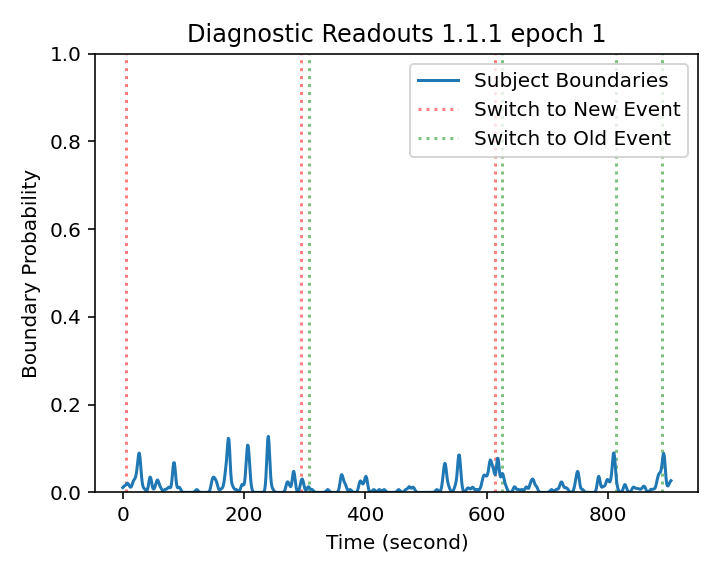

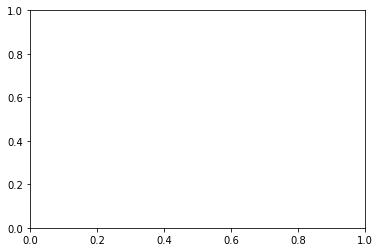

In [12]:
# Tabbed Version
dashboard = pn.Column(
    pn.Row(title),
    pn.Row(tag_select,run_select,update_run_options,update_epoch_options,listen_to_run),
    pn.Row(epoch_select),
    pn.Row(pn.Tabs(('diagnostic readouts',plot_diagnostic_readouts),
            ('posterior prior likelihood',plot_post_prior_lik),
            ('active models',plot_active_models),dynamic=True))
)

# Launch the dashboard
dashboard.servable()